In [4]:
from ultralytics import YOLO
import cv2
import numpy as np
from collections import defaultdict
from cap_from_youtube import cap_from_youtube
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # to avoid OMP conficts

In [5]:
# Load an official or custom model
# model = YOLO('../models/yolov8n.pt')  # Load an official Detect model
model = YOLO('../models/yolov8x.pt')  # Load an official Detect model

# Tracking from a video file or YouTube url

In [6]:
# Open the video file
# fname="highway_drone_footage"
# fname="apollo15_10_1_1st"
# fname="cars"
# cap = cv2.VideoCapture("../videos/"+fname+".mp4")

# Open the video from YouTube
fname="from_yt_5"
# cap = cap_from_youtube("https://youtu.be/7HaJArMDKgI?si=T0Bb3zOcz-YiOnMF", '720p') # 1
# cap = cap_from_youtube("https://youtu.be/Y1jTEyb3wiI?si=-gU51avblW5Qo-ij", '720p') # 2
# cap = cap_from_youtube("https://youtu.be/jM2VrPE5kFg?si=RXfsB63fA58TuBSi", '720p') # 3
# cap = cap_from_youtube("https://youtu.be/CftLBPI1Ga4?si=N69rX1Bo3w9S6qjq", '1080p') # 4 (busy street with cars)
cap = cap_from_youtube("https://youtu.be/dDE3d6mEfn8?si=s5fAKjGVaHhfeLCQ", '2160p50') # 4 (mumbai street)


[youtube] Extracting URL: https://youtu.be/dDE3d6mEfn8?si=s5fAKjGVaHhfeLCQ
[youtube] dDE3d6mEfn8: Downloading webpage


[youtube] dDE3d6mEfn8: Downloading ios player API JSON
[youtube] dDE3d6mEfn8: Downloading m3u8 information


In [7]:
# Store the track history
track_history = defaultdict(lambda: [])

# Below VideoWriter object will create a frame of above defined The output  
# is stored in 'output.mp4' file. 
output_video = cv2.VideoWriter("../output/"+fname+"_output.mp4",  
                         cv2.VideoWriter_fourcc(*'mp4v'), # writer object # XVID
                        #  cv2.VideoWriter_fourcc(*'XVID'),
                        #  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                         int(cap.get(cv2.CAP_PROP_FPS)), # FPS
                         (852,480)) # frame size

# Loop through the video frames
i=0
while cap.isOpened():
    i+=1
    # Read a frame from the video
    success, frame = cap.read()

    if success:

        print(frame.shape)
        frame = cv2.resize(frame, dsize=(852,480))# reshape to 480, 852
        print(frame.shape)

        # Run YOLOv8 tracking on the frame, persisting tracks between frames
        results = model.track(frame, persist=True,tracker="bytetrack.yaml") # , show=True, stream=True

        try:
            # Get the boxes and track IDs
            boxes = results[0].boxes.xywh.cpu()
            track_ids = results[0].boxes.id.int().cpu().tolist()

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Plot the tracks
            for box, track_id in zip(boxes, track_ids):
                x, y, w, h = box
                track = track_history[track_id]
                track.append((float(x), float(y)))  # x, y center point
                if len(track) > 30:  # retain 90 tracks for 90 frames
                    track.pop(0)

                # Draw the tracking lines
                points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
                cv2.polylines(annotated_frame, [points], isClosed=False, color=(255,0,0), thickness=10)

        except:
            annotated_frame = frame

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
        
        # Display the annotated frame (requires X-forwarding ...)
        # cv2.imshow("YOLOv8 Tracking", annotated_frame)

        # write the frame to the output file
        output_video.write(annotated_frame)

        # save every n-th frame as jpg
        n=500
        if i % n == 0:
            print('saving '+str(n)+'-th frame ...')
            cv2.imwrite("../output/"+fname+"_frame_%d.jpg" % i, annotated_frame)     # save frame as JPEG file 

        # except:
        #     print("No detection in this frame, skipping ...")



        if i==80:
            print("ok, that's enough ...")
            break

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        print("failed to read the frame :<")
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
output_video.release()
cv2.destroyAllWindows()

(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 57.8ms
Speed: 2.3ms preprocess, 57.8ms inference, 18.9ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 30.1ms
Speed: 1.0ms preprocess, 30.1ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 29.7ms
Speed: 2.3ms preprocess, 29.7ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 (no detections), 29.6ms
Speed: 2.8ms preprocess, 29.6ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 2 cars, 29.7ms
Speed: 1.7ms preprocess, 29.7ms inference, 53.9ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 384x640 10 cars, 26.6ms
Speed: 1.4ms preprocess, 26.6ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)
(2160, 3840, 3)
(480, 852, 3)

0: 38

KeyboardInterrupt: 

# Tracking on KITTI

In [128]:
from collections import defaultdict
import cv2
import numpy as np

from ultralytics import YOLO

model = YOLO("../models/yolov8n_trained_on_camera_1_KITTI.pt")

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utils/") # Adds utils python modules path.
from kitti_foundation import Kitti, Kitti_util
%matplotlib inline

v2c_filepath = '../datasets/KITTI/2011_09_26/calib_velo_to_cam.txt'
c2c_filepath = '../datasets/KITTI/2011_09_26/calib_cam_to_cam.txt'
xml_path = "../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml"

velo_path = '../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/velodyne_points/data'
camera_path = '../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/'

frame_no = 115
v_fov, h_fov = (-24.9, 2.0), (-90, 90) # field of view

In [130]:
def draw_tracklets(check):
    """ draw 3d bounding boxes around annotated objects """
    import cv2
    tracklet_, type_ = check.tracklet_info

    tracklet2d = []
    for i, j in zip(tracklet_[frame_no], type_[frame_no]):
        point = i.T
        chk,_ = check._Kitti_util__velo_2_img_projection(point)
        tracklet2d.append(chk)

    type_c = { 'Car': (0, 0, 255), 'Van': (0, 255, 0), 'Truck': (255, 0, 0), 'Pedestrian': (0,255,255), \
        'Person (sitting)': (255, 0, 255), 'Cyclist': (255, 255, 0), 'Tram': (0, 0, 0), 'Misc': (255, 255, 255)}

    line_order = ([0, 1], [1, 2],[2, 3],[3, 0], [4, 5], [5, 6], \
            [6 ,7], [7, 4], [4, 0], [5, 1], [6 ,2], [7, 3])

    for i, j in zip(tracklet2d, type_[frame_no]):
        for k in line_order:    
            cv2.line(image, (int(i[0][k[0]]), int(i[1][k[0]])), (int(i[0][k[1]]), int(i[1][k[1]])), type_c[j], 2)
        cv2.putText(image, j, (int(i[0][k[0]]), int(-10+i[1][k[0]])), cv2.FONT_HERSHEY_PLAIN, 1, type_c[j], 2)

Just using a regular camera image

In [131]:
# read left camera image
with_tracklets = True
image_type = 'color'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'gray image' , image_02 = 'color image'

image_path = camera_path+'image_' + mode + '/data'
check = Kitti_util(frame=frame_no, velo_path=velo_path, camera_path=image_path, \
                   xml_path=xml_path, v2c_path=v2c_filepath, c2c_path=c2c_filepath)
image = check.camera_file

results = model.track(source=image, persist=True,tracker="bytetrack.yaml")

txt=""
if with_tracklets:
    draw_tracklets(check)
    txt="_with_tracklets"

for result in results:
    result.save(filename="../output/result_only_camera_frame_"+str(frame_no)+""+txt+".jpg")  # save to disk


parsing tracklet file ../datasets/KITTI/2011_09_26/2011_09_26_drive_0005_sync/tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets

0: 384x1248 2 Cars, 1 Van, 1 Cyclist, 2 DontCares, 2.1ms
Speed: 1.4ms preprocess, 2.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 1248)


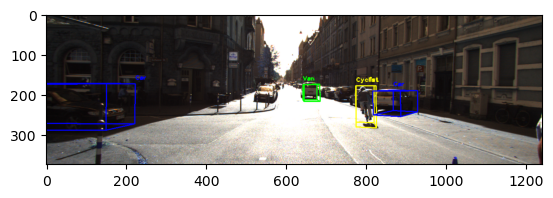

In [266]:
plt.imshow(image)

Using a camera image with projected lidar data

In [139]:
model = YOLO("../models/yolov8n_trained_on_lidar_KITTI.pt")

In [93]:
def print_projection_plt(points, color, image, velo_only=False):
    """ project converted velodyne points into camera image """
    if velo_only:
        hsv_image=image*0
    else:
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    for i in range(points.shape[1]):
        cv2.circle(hsv_image, (np.int32(points[0][i]),np.int32(points[1][i])),1, (int(color[i]),255,255),-1)

    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)

In [95]:
def read_calib_file(filepath):
    """Read in a calibration file and parse into a dictionary."""
    import numpy as np
    
    data = {}

    with open(filepath, 'r') as f:
        for line in f.readlines():
            try:
                key, value = line.split(':', 1)
            except ValueError:
                key, value = line.split(' ', 1)
            # The only non-float values in these files are dates, which
            # we don't care about anyway
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass

    return data


In [113]:
image_type = 'color'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'gray image' , image_02 = 'color image'

image_path = camera_path+'image_' + mode + '/data'
res = Kitti_util(frame=frame_no, camera_path=image_path, velo_path=velo_path, \
                v2c_path=v2c_filepath, c2c_path=c2c_filepath)

img, pnt, c_ = res.velo_projection_frame(v_fov=v_fov, h_fov=h_fov)

image = print_projection_plt(pnt, c_, img, velo_only=True) # img*0 
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # to grayscale

results = model.track(source=image, persist=True,tracker="bytetrack.yaml")

txt=""

for result in results:
    result.save(filename="../output/result_camera_with_lidar_proj_frame_"+str(frame_no)+""+txt+".jpg")  # save to disk



0: 384x1248 (no detections), 2.4ms
Speed: 19.5ms preprocess, 2.4ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)


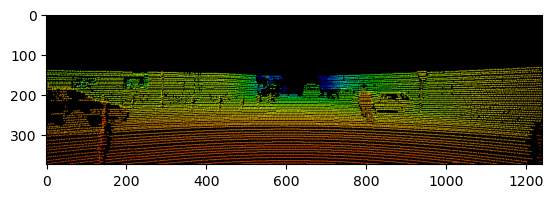

In [99]:
plt.imshow(image)

In [155]:
# Load the YOLOv8 model
# model = YOLO("yolov8n.pt") # pretrained one
# model = YOLO("../models/yolov8n_trained_on_camera_1_KITTI.pt") # trained on main camera images by us
model = YOLO("../models/yolov8n_trained_on_lidar_KITTI.pt") # trained on lidar projections by us
print(len(list(model.names.values())))
print(list(model.names.values()))

txt=""
image_type = 'color'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'gray image' , image_02 = 'color image'
image_path = camera_path+'image_' + mode + '/data'

9
['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'PersonSitting', 'DontCare']


In [156]:
# Store the track history
track_history = defaultdict(lambda: [])

# Below VideoWriter object will create a frame of above defined The output  
# is stored in 'output.mp4' file. 
output_video = cv2.VideoWriter("../output/kitti_test_output.mp4",  
                         cv2.VideoWriter_fourcc(*'mp4v'), # writer object # XVID or mp4v
                        #  cv2.VideoWriter_fourcc(*'XVID'),
                        #  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                         10, # FPS
                         image.shape[:2]) # frame size
with_lidar = True
txt=""
for frame_no in range(1,20):

    

    # read the next KITTI frame:
    img, pnt, c_ = Kitti_util(
        frame=frame_no, camera_path=image_path, velo_path=velo_path, v2c_path=v2c_filepath, c2c_path=c2c_filepath
    ).velo_projection_frame(v_fov=v_fov, h_fov=h_fov)
    if with_lidar:
        txt="lidar_"
        frame = print_projection_plt(pnt, c_, img, velo_only=True)
    else:
        frame = img

    # print(frame.shape)
    cv2.resize(frame, dsize=image.shape[:2]) # reshape to 480, 852
    # print(frame.shape)

    # do the object detection for tracking:
    results = model.track(
        source=frame, 
        persist=True,
        tracker="bytetrack.yaml"
    )

    try: # will work ONLY if there was some detection!
        # Get the boxes and track IDs
        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Plot the tracks
        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = track_history[track_id]
            track.append((float(x), float(y)))  # x, y center point
            if len(track) > 30:  # retain 90 tracks for 90 frames
                track.pop(0)

            # Draw the tracking lines
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [points], isClosed=False, color=(0,0,255), thickness=10)
    except:
        annotated_frame = frame

    if frame_no % 5 == 0:
        cv2.imwrite("../output/KITTI_"+txt+"frame_%d.jpg" % frame_no, annotated_frame)     # save frame as JPEG file

    # write the frame to the output file
    output_video.write(annotated_frame)

    # Display the annotated frame
    # cv2.imshow("YOLOv8 Tracking", annotated_frame)


output_video.release()
cv2.destroyAllWindows()


0: 384x1248 (no detections), 2.3ms
Speed: 1.2ms preprocess, 2.3ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)

0: 384x1248 (no detections), 2.1ms
Speed: 1.4ms preprocess, 2.1ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)

0: 384x1248 (no detections), 2.1ms
Speed: 1.3ms preprocess, 2.1ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)

0: 384x1248 (no detections), 2.1ms
Speed: 1.3ms preprocess, 2.1ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)

0: 384x1248 (no detections), 2.1ms
Speed: 1.3ms preprocess, 2.1ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)

0: 384x1248 (no detections), 2.2ms
Speed: 1.4ms preprocess, 2.2ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)

0: 384x1248 (no detections), 2.1ms
Speed: 1.3ms preprocess, 2.1ms inference, 0.2ms postprocess per image at shape (1, 3, 384, 1248)

0: 384x1248 (no detections), 2.0ms
Speed: 1.4ms preprocess, 2.0ms in

# Save the Lidar projections as images for processing with Ultralytics

Based on https://github.com/kuixu/kitti_object_vis/blob/master/kitti_object.py

In [62]:
def get_lidar(lidar_dir='../datasets/KITTI/training/velodyne/0000',idx=0,point_cloud_only=False,distance_only=False):
    """
    Read a lidar file

    The format is (x,y,z,r)
    """
    import os
    import numpy as np
    
    lidar_file = os.path.join(lidar_dir, '{:06d}.bin'.format(idx))
    assert os.path.isfile(lidar_file)
    if point_cloud_only:
        return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)[:, :3]
    elif distance_only:
        return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)[:, 3]
    else:
        return np.fromfile(lidar_file, dtype=np.float32).reshape(-1, 4)

In [63]:
def project_velo_to_rect(self, pts_3d_velo):
    pts_3d_ref = self.project_velo_to_ref(pts_3d_velo)
    return self.project_ref_to_rect(pts_3d_ref)

In [64]:
def project_velo_to_image(self, pts_3d_velo):
    """ Input: nx3 points in velodyne coord.
        Output: nx2 points in image2 coord.
    """
    pts_3d_rect = self.project_velo_to_rect(pts_3d_velo)
    return self.project_rect_to_image(pts_3d_rect)

In [65]:
def get_lidar_in_image_fov(
    pc_velo, calib, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0
):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = calib.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo

In [114]:
def show_lidar_on_image(pc_velo, img, calib, img_width, img_height):
    """ Project LiDAR points to image """
    import cv2
    
    img =  np.copy(img)
    imgfov_pc_velo, pts_2d, fov_inds = get_lidar_in_image_fov(
        pc_velo, calib, 0, 0, img_width, img_height, True
    )
    imgfov_pts_2d = pts_2d[fov_inds, :]
    imgfov_pc_rect = calib.project_velo_to_rect(imgfov_pc_velo)

    import matplotlib.pyplot as plt

    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255

    for i in range(imgfov_pts_2d.shape[0]):
        depth = imgfov_pc_rect[i, 2]
        color = cmap[int(640.0 / depth), :]
        cv2.circle(
            img,
            (int(np.round(imgfov_pts_2d[i, 0])), int(np.round(imgfov_pts_2d[i, 1]))),
            1,
            color=tuple(color),
            thickness=-1,
        )
    # cv2.imshow("projection", img)
    # plt.imshow(img)
    # cv2.imwrite("projection.jpg", img) 
    return img

/tmp/ipykernel_1068917/3938255837.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("hsv", 256)


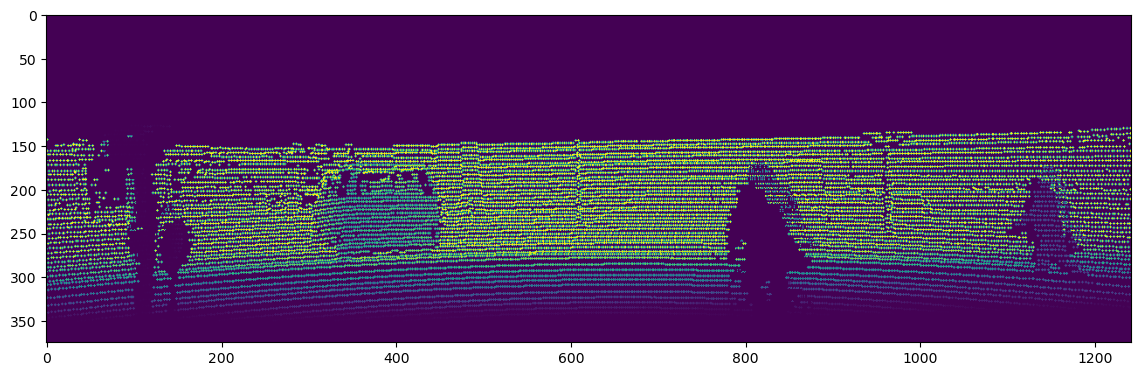

In [116]:

import sys
sys.path.append("../utils/") # Adds utils python modules path.
import kitti_util as utils
import numpy as np
import matplotlib.pyplot as plt
import cv2


width=1242
height=375
lidar_point_cloud = get_lidar(point_cloud_only=True)
lidar_distance = get_lidar(distance_only=True)
calibration = utils.Calibration("../datasets/KITTI/training/calib/0000.txt")
img_lidar = show_lidar_on_image(pc_velo=lidar_point_cloud, img=np.zeros((height,width)), calib=calibration, img_width=width, img_height=height)
# img_lidar = cv2.cvtColor(img_lidar, cv2.COLOR_BGR2RGB)

fig_lidar = plt.figure(figsize=(14, 7))
ax_lidar = fig_lidar.subplots()
ax_lidar.imshow(img_lidar)
plt.show()

In [1]:
# now, let's use the function we defined:
import sys
sys.path.append('../src/')
sys.path.append("../utils/") # Adds utils python modules path.
import kitti_util as utils
from KITTI_to_Ultralytics import lidar_to_images

In [2]:
lidar_to_images(
    kitti_dir="../datasets/KITTI/",
    subset="training",
)

Processing scene  0000
Processing scene  0001
../datasets/KITTI/training/velodyne/0001/000177.bin  missing!
../datasets/KITTI/training/velodyne/0001/000177.bin  missing!
../datasets/KITTI/training/velodyne/0001/000178.bin  missing!
../datasets/KITTI/training/velodyne/0001/000178.bin  missing!
../datasets/KITTI/training/velodyne/0001/000179.bin  missing!
../datasets/KITTI/training/velodyne/0001/000179.bin  missing!
../datasets/KITTI/training/velodyne/0001/000180.bin  missing!
../datasets/KITTI/training/velodyne/0001/000180.bin  missing!
Processing scene  0002
Processing scene  0003
Processing scene  0004
Processing scene  0005
Processing scene  0006
Processing scene  0007
Processing scene  0008
Processing scene  0009
Processing scene  0010
Processing scene  0011
Processing scene  0012
Processing scene  0013
Processing scene  0014
Processing scene  0015
Processing scene  0016
Processing scene  0017
Processing scene  0018
Processing scene  0019
Processing scene  0020


In [1]:
# we move the part of the lidar projections to the test set:
import sys
sys.path.append('../src/')
from KITTI_to_Ultralytics import split_train_test
split_train_test(
        kitti_dir="../datasets/KITTI/",
        mode="simple",
        start_scene_id=0,
        stop_scene_id=999999,
        only_lidar=True,
)

processing scene  0000
processing scene  0001
processing scene  0002
processing scene  0003
processing scene  0004
processing scene  0005
processing scene  0006
processing scene  0007
processing scene  0008
processing scene  0009
processing scene  0010
processing scene  0011
processing scene  0012
processing scene  0013
processing scene  0014
processing scene  0015
processing scene  0016
processing scene  0017
copying the test labels
copying the test lidar projection images
processing scene  0018
copying the test labels
copying the test lidar projection images
processing scene  0019
copying the test labels
copying the test lidar projection images
processing scene  0020
copying the test labels
copying the test lidar projection images


# Translate KITTI labels to Ultralytics format

In [1]:
import pandas as pd

In [2]:
"""
KITTI format: 
#Values    Name      Description
----------------------------------------------------------------------------
   1    frame        Frame within the sequence where the object appearers
   1    track id     Unique tracking id of this object within this sequence
   1    type         Describes the type of object: 'Car', 'Van', 'Truck',
                     'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram',
                     'Misc' or 'DontCare'
   1    truncated    Integer (0,1,2) indicating the level of truncation.
                     Note that this is in contrast to the object detection
                     benchmark where truncation is a float in [0,1].
   1    occluded     Integer (0,1,2,3) indicating occlusion state:
                     0 = fully visible, 1 = partly occluded
                     2 = largely occluded, 3 = unknown
   1    alpha        Observation angle of object, ranging [-pi..pi]
   4    bbox         2D bounding box of object in the image (0-based index):
                     contains left, top, right, bottom pixel coordinates <----- [top & bottom seem swapped BUT they are NOT! the y axis goes downwards!!!]
   3    dimensions   3D object dimensions: height, width, length (in meters)
   3    location     3D object location x,y,z in camera coordinates (in meters)
   1    rotation_y   Rotation ry around Y-axis in camera coordinates [-pi..pi]
   1    score        Only for results: Float, indicating confidence in
                     detection, needed for p/r curves, higher is better.
"""
colnames=['frame','track_id','type','truncated','occluded','alpha',
          'bbox_left','bbox_top','bbox_right','bbox_bottom',
          'obj_height','obj_width','obj_length',
          'obj_x','obj_y','obj_z','rotation_y','score',]

In [3]:
temp=pd.read_csv("/home/piokal/automotive-tracking/datasets/KITTI/training/label_02/0000.txt",sep=" ",header=None,names=colnames) # ,names=colnames

In [4]:
print(temp)

,frame,track_id,type,truncated,occluded,alpha,bbox_left,bbox_top,bbox_right,bbox_bottom,obj_height,obj_width,obj_length,obj_x,obj_y,obj_z,rotation_y,score
0,0,-1,DontCare,-1,-1,-10.000000,219.310000,188.490000,245.500000,218.560000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000,NaN
1,0,-1,DontCare,-1,-1,-10.000000,47.560000,195.280000,115.480000,221.480000,-1000.000000,-1000.000000,-1000.000000,-10.000000,-1.000000,-1.000000,-1.000000,NaN
2,0,0,Van,0,0,-1.793451,296.744956,161.752147,455.226042,292.372804,2.000000,1.823255,4.433886,-4.552284,1.858523,13.410495,-2.115488,NaN
3,0,1,Cyclist,0,0,-1.936993,737.619499,161.531951,931.112229,374.000000,1.739063,0.824591,1.785241,1.640400,1.675660,5.776261,-1.675458,NaN
4,0,2,Pedestrian,0,0,-2.523309,1106.137292,166.576807,1204.470628,323.876144,1.714062,0.767881,0.972283,6.301919,1.652419,8.455685,-1.900245,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,153,10,Car,0,2,-1.818856,680.294919,177.511028,842.313244,284.070033,1.524000,1.728591,3.894227,2.353367,1.622590,12.436503,-1.637280,NaN
1085,153,11,Car,0,2,1.864481,245.920800,194.456182,394.817829,286.444967,1.444000,1.595116,3.791789,-5.458963,1.908188,13.979427,1.497916,NaN
1086,153,12,Pedestrian,1,0,0.826456,1185.199080,151.165841,1241.000000,348.552707,1.688000,0.800000,0.884000,5.739732,1.500532,6.279632,1.543272,NaN
1087,153,13,Car,0,0,1.773993,344.361560,188.772369,430.531955,248.482384,1.422414,1.512803,3.707634,-6.033258,1.888008,19.788795,1.481180,NaN


In [5]:
"""Ultralytics label format: 

    class x_center y_center width height

- Box coordinates must be in normalized xywh format (from 0 to 1). If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Class numbers are zero-indexed (start from 0).
"""
ultra_colnames = ['class','x_center','y_center','width','height']

In [6]:
ultra_df = pd.DataFrame(columns=ultra_colnames)

In [8]:
ultra_df['class']=temp['type']

# We need to norm to (0,1) by the image size:
img_width=1242
img_height=375

ultra_df['x_center']=0.5*(temp['bbox_left']+temp['bbox_right'])/img_width
ultra_df['y_center']=0.5*(temp['bbox_top']+temp['bbox_bottom'])/img_height
ultra_df['width']=(temp['bbox_right']-temp['bbox_left'])/img_width
ultra_df['height']=(temp['bbox_bottom']-temp['bbox_top'])/img_height

In [10]:
class_name_to_id = {
    'Car'            : 0,
    'Pedestrian'     : 1,
    'Van'            : 2,
    'Cyclist'        : 3,
    'Truck'          : 4,
    'Misc'           : 5,
    'Tram'           : 6,
    'Person_sitting' : 7,
    'DontCare'       : 8,
}
ultra_df['class']=[class_name_to_id[c] for c in ultra_df['class']]

In [96]:
ultra_df.to_csv('../datasets/KITTI_for_YOLO/labels/test.txt',sep=' ',index=None, float_format='%.6f',header=None)

In [1]:
# now, let's use the function we defined:
import sys
sys.path.append('../src/')
from KITTI_to_Ultralytics import kitti_to_ultra_labels

In [2]:
kitti_to_ultra_labels(kitti_dir="../datasets/KITTI/",subset="training")

Converting the KITTI labels ...
Processing scene  0000
Processing scene  0001
Processing scene  0002
Processing scene  0003
Processing scene  0004
Processing scene  0005
Processing scene  0006
Processing scene  0007
Processing scene  0008
Processing scene  0009
Processing scene  0010
Processing scene  0011
Processing scene  0012
Processing scene  0013
Processing scene  0014
Processing scene  0015
Processing scene  0016
Processing scene  0017
Processing scene  0018
Processing scene  0019
Processing scene  0020


# Split into training and test set (the KITTI testing set has no labels!)

In [1]:
import sys
sys.path.append('../src/')
from KITTI_to_Ultralytics import split_train_test

In [2]:
split_train_test(start_scene_id=0,only_labels=True)

processing scene  0000
processing scene  0001
processing scene  0002
processing scene  0003
processing scene  0004
processing scene  0005
processing scene  0006
processing scene  0007
processing scene  0008
processing scene  0009
processing scene  0010
processing scene  0011
processing scene  0012
processing scene  0013
processing scene  0014
processing scene  0015
processing scene  0016
processing scene  0017
copying the test labels
processing scene  0018
copying the test labels
processing scene  0019
copying the test labels
processing scene  0020
copying the test labels


# Train the YOLO model on KITTI

In [1]:
from ultralytics import YOLO

model = YOLO("../models/yolov8n.pt")

### Train on regular camera images

In [3]:
# Train the model
results = model.train(data="/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/KITTI.yaml", 
                      epochs=10, imgsz=1248, project='../output/',name='yolov8n_trained_on_camera_1_KITTI')

New https://pypi.org/project/ultralytics/8.2.48 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.42 🚀 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
engine/trainer: task=detect, mode=train, model=../models/yolov8n.pt, data=/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/KITTI.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=1248, save=True, save_period=-1, cache=False, device=None, workers=8, project=../output/, name=yolov8n_trained_on_camera_1_KITTI, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, 

AMP: checks passed ✅


train: Scanning /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/training/camera_1/labels.cache... 5544 images, 84 backgrounds, 0 corrupt: 100%|██████████| 5628/5628 [00:00<?, ?it/s]
val: Scanning /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/camera_1/labels.cache... 2380 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2380/2380 [00:00<?, ?it/s]


Plotting labels to ../output/yolov8n_trained_on_camera_1_KITTI/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1248 train, 1248 val
Using 8 dataloader workers
Logging results to ../output/yolov8n_trained_on_camera_1_KITTI
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10        14G      1.902      4.552      1.423        116       1248:   8%|▊         | 27/352 [00:17<03:31,  1.53it/s]


KeyboardInterrupt: 

In [5]:
# move the trained model to the models/ directory:
!cp -v automotive-tracking/output/yolov8n_trained_on_camera_1_KITTI/weights/best.pt ../models/yolov8n_trained_on_camera_1_KITTI.pt

'yolov8n.pt' -> 'yolov8n_2.pt'


### Train on lidar data projected onto camera image format

In [4]:
# Train the model
results = model.train(data="/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/KITTI_lidar.yaml", epochs=10, imgsz=1248,
                      project='../output/',name='yolov8n_trained_on_lidar_KITTI')

New https://pypi.org/project/ultralytics/8.2.46 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.42 🚀 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
engine/trainer: task=detect, mode=train, model=../models/yolov8n.pt, data=/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/KITTI_lidar.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=1248, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms

train: Scanning /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/training/lidar/labels... 7920 images, 84 backgrounds, 0 corrupt: 100%|██████████| 8004/8004 [00:02<00:00, 3924.11it/s]


train: New cache created: /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/training/lidar/labels.cache


val: Scanning /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/lidar/labels... 2380 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2380/2380 [00:00<00:00, 6992.84it/s]

val: New cache created: /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/lidar/labels.cache


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1248 train, 1248 val
Using 8 dataloader workers
Logging results to runs/detect/train8
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      9.01G      2.144      3.417      1.707         50       1248: 100%|██████████| 501/501 [01:41<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 12.84it/s]


                   all       2380      23381      0.489      0.297      0.236      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      8.53G      1.681      1.873      1.408         42       1248: 100%|██████████| 501/501 [01:40<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.01it/s]


                   all       2380      23381      0.574      0.369      0.356      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      8.77G      1.581      1.514      1.352         29       1248: 100%|██████████| 501/501 [01:40<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.25it/s]


                   all       2380      23381      0.472      0.506      0.474      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      8.89G      1.501      1.343      1.301         27       1248: 100%|██████████| 501/501 [01:41<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.31it/s]


                   all       2380      23381      0.589      0.529      0.566      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      8.79G       1.43       1.22      1.259         33       1248: 100%|██████████| 501/501 [01:42<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.52it/s]


                   all       2380      23381      0.665      0.571      0.622      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      8.89G      1.371      1.132      1.221         36       1248: 100%|██████████| 501/501 [01:42<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.45it/s]


                   all       2380      23381       0.68      0.609      0.676      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      8.89G      1.319      1.062      1.195         36       1248: 100%|██████████| 501/501 [01:42<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.52it/s]


                   all       2380      23381      0.746      0.664      0.763      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      8.77G      1.272     0.9962      1.167         33       1248: 100%|██████████| 501/501 [01:43<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.51it/s]


                   all       2380      23381      0.786      0.697      0.795      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      8.49G      1.225     0.9407      1.141         24       1248: 100%|██████████| 501/501 [01:42<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.18it/s]


                   all       2380      23381      0.816      0.714      0.819      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      8.23G      1.187     0.8961      1.121         43       1248: 100%|██████████| 501/501 [01:43<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:05<00:00, 14.60it/s]


                   all       2380      23381       0.84      0.713      0.826      0.568

10 epochs completed in 0.301 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 6.3MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics YOLOv8.2.42 🚀 Python-3.12.3 torch-2.3.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
Model summary (fused): 168 layers, 3007403 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 75/75 [00:06<00:00, 11.87it/s]


                   all       2380      23381      0.841      0.712      0.826      0.568
                   Car       1890       7778       0.91       0.88      0.947      0.734
            Pedestrian       1196       6870      0.838      0.699      0.837      0.518
                   Van        999       1307      0.814      0.784      0.881       0.66
               Cyclist        287        409      0.923      0.626      0.797      0.519
                 Truck        145        145      0.867      0.942      0.944      0.775
                  Misc        414        532      0.808      0.658      0.816      0.599
                  Tram        182        417      0.863      0.856      0.926      0.635
         PersonSitting        201        509      0.739       0.44      0.628      0.347
              DontCare       2267       5414       0.81       0.52      0.661      0.328
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect

In [5]:
# move the trained model to the models/ directory:
!cp -v automotive-tracking/output/yolov8n_trained_on_lidar_KITTI/weights/best.pt ../models/yolov8n_trained_on_lidar_KITTI.pt

# Tracking on trained models

In [172]:
# Load the YOLOv8 model
# model = YOLO("yolov8n.pt") # pretrained one
model = YOLO("../models/yolov8n_trained_on_camera_1_KITTI.pt") # trained on main camera images by us
# model = YOLO("../models/yolov8n_trained_on_lidar_KITTI.pt") # trained on lidar projections by us
print(len(list(model.names.values())))
print(list(model.names.values()))

txt=""
image_type = 'color'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'gray image' , image_02 = 'color image'
image_path = camera_path+'image_' + mode + '/data'

9
['Car', 'Pedestrian', 'Van', 'Cyclist', 'Truck', 'Misc', 'Tram', 'PersonSitting', 'DontCare']


In [173]:
# Store the track history
track_history = defaultdict(lambda: [])

# Below VideoWriter object will create a frame of above defined The output  
# is stored in 'output.mp4' file. 
output_video = cv2.VideoWriter("../output/kitti_test_output.mp4",  
                         cv2.VideoWriter_fourcc(*'mp4v'), # writer object # XVID or mp4v
                        #  cv2.VideoWriter_fourcc(*'XVID'),
                        #  cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                         10, # FPS
                         image.shape[:2]) # frame size
with_lidar = False
txt=""
for frame_no in range(1,20):

    # read the next KITTI frame:
    if with_lidar:
        txt="lidar_"
        frame = "/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/lidar/images/scene_0019_frame_"+str(frame_no).zfill(6)+".jpg"
    else:
        frame = "/home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/camera_1/images/scene_0019_frame_"+str(frame_no).zfill(6)+".jpg"

    # do the object detection for tracking:
    results = model.track(
        source=frame, 
        persist=True,
        tracker="bytetrack.yaml"
    )

    try: # will work ONLY if there was some detection!
        # Get the boxes and track IDs
        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()

        # Visualize the results on the frame
        annotated_frame = results[0].plot()

        # Plot the tracks
        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = track_history[track_id]
            track.append((float(x), float(y)))  # x, y center point
            if len(track) > 30:  # retain 90 tracks for 90 frames
                track.pop(0)

            # Draw the tracking lines
            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotated_frame, [points], isClosed=False, color=(0,0,255), thickness=10)
    except:
        annotated_frame = frame

    if frame_no % 5 == 0:
        cv2.imwrite("../output/KITTI_"+txt+"frame_%d.jpg" % frame_no, annotated_frame)     # save frame as JPEG file

    # write the frame to the output file
    output_video.write(annotated_frame)

    # Display the annotated frame
    # cv2.imshow("YOLOv8 Tracking", annotated_frame)


output_video.release()
cv2.destroyAllWindows()

image 1/1 /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/camera_1/images/scene_0019_frame_000001.jpg: 384x1248 2 Cars, 1 Pedestrian, 1 Cyclist, 2.2ms
Speed: 1.2ms preprocess, 2.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 1248)

image 1/1 /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/camera_1/images/scene_0019_frame_000002.jpg: 384x1248 2 Cars, 1 Pedestrian, 1 Cyclist, 1.8ms
Speed: 1.3ms preprocess, 1.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 1248)

image 1/1 /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/camera_1/images/scene_0019_frame_000003.jpg: 384x1248 2 Cars, 1 Pedestrian, 1 Cyclist, 1.9ms
Speed: 1.3ms preprocess, 1.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 1248)

image 1/1 /home/piokal/automotive-tracking/datasets/KITTI_for_YOLO/testing/camera_1/images/scene_0019_frame_000004.jpg: 384x1248 2 Cars, 1 Pedestrian, 1 Cyclist, 1.8ms
Speed: 1.3ms preprocess, 1.8ms inf